In [1]:
import gym
from gym import wrappers
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import itertools

if "../../" not in sys.path:
  sys.path.append("../../") 

from lib import plotting
matplotlib.style.use('ggplot')

from gym.envs.registration import register
register(
        id = 'FrozenLake-v3',
        entry_point = 'gym.envs.toy_text:FrozenLakeEnv',
        kwargs = {'map_name' : '4x4', 'is_slippery':False}
)

env_deter = gym.make('FrozenLake-v3')
env = gym.make('FrozenLake-v0')
TARGET_AVG_REWARD = 0.78
TARGET_EPISODE_INTERVAL = 100
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']

[2017-03-16 15:20:05,477] Making new env: FrozenLake-v3
[2017-03-16 15:20:05,532] Making new env: FrozenLake-v0


## summary
### getting started
- make sure to get your API key from openai.com and place it in your bashrc, zshrc ... (e.g. export OPENAI_API_KEY="your_api_key")
- install all dependencies 
- profit!! (remember to play around with the hyperparams)

### Q-learning without alpha
- This sucks for stochastic environments. 
- Check the relative performance v3 vs. v0 (slippery = False vs. True).

### Q-learning with alpha
- Alpha allows us to update our Q-table slowly.
- can accomodate stochasticity (the same (s, a) pair can yield different (s', r))

#### decaying episilon-greedy policy
- decaying strategy can add significant variability (1 / episode_index seems to be good)
- breaking ties with random action helps a lot in the beginning

#### adding decaying noise to policy
- no tie breaking needed
- should add uniform vs. varying randomness to actions?

### SARSA
- (optional) using Q[next_state,] instead of using maxQ[next_state]

#### discussion
- how can we do better
- e-greedy vs. noise: which's better?
- efficient ways to search for good hyperparameters
- modifying rewards to a more dramatic version useful? (how to best incorporate what we already know about env)

In [2]:
# utility functions
def log_episode(i_epi, n_epi):
    if (i_epi + 1) % 100 == 0:
        print("\rEpisode {}/{}.".format(i_epi + 1, n_epi), end="")
        sys.stdout.flush()


def is_solved(stats, target, interval):
    """
    checks if openai's criteria has been met
    """
    # FrozenLake-v0 is considered "solved" when the agent
    # obtains an average reward of at least 0.78 over 100
    # consecutive episodes.

    def moving_avg(x, n=100):
        return np.convolve(x, np.ones((n,))/n, mode='valid')

    ma = moving_avg(stats.episode_rewards, interval)
    peaks = np.where(ma > target)[0]
    if len(peaks) > 0:
        print("solved after {} episodes".format(peaks[0]))
        return True
    else:
        print("did not pass the openai criteria")
        return False

In [3]:
def qlearning_noise(env, n_episodes=2000, gamma=0.95):
    print("Q space initialized: {} x {}".format(env.nS, env.nA))

    Q = np.zeros([env.nS, env.nA])
    # policy: pi(state) -> prob. distribution of actions
    policy = make_noisy_policy(Q, env.nA)

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(n_episodes),
        episode_rewards=np.zeros(n_episodes))

    for i in range(n_episodes):
        # useful for debugging
        if (i + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i + 1, n_episodes), end="")
            sys.stdout.flush()

        s = env.reset()
        done = False
        total_reward = 0

        for t in itertools.count():
            # Choose action by noisy probs
            probs = policy(s, i)
            a = np.random.choice(np.arange(env.nA), p=probs)
            # take a step
            next_s, r, done, _ = env.step(a)

            # backup Q, no alpha
            td_target = r + gamma * np.max(Q[next_s, :])
            Q[s, a] = td_target

            s = next_s
            total_reward += r
            if done:
                break

        # Update statistics
        stats.episode_rewards[i] += total_reward
        stats.episode_lengths[i] = t

    return Q, stats

def qlearning_e_greedy(env, n_episodes=2000, gamma=0.95):
    print("Q space initialized: {} x {}".format(env.nS, env.nA))

    Q = np.zeros([env.nS, env.nA])
    # policy: pi(state) -> prob. distribution of actions
    policy = make_decay_e_greedy_policy(Q, env.nA)
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(n_episodes),
        episode_rewards=np.zeros(n_episodes))

    for i in range(n_episodes):
        # useful for debugging
        if (i + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i + 1, n_episodes), end="")
            sys.stdout.flush()

        s = env.reset()
        done = False
        total_reward = 0

        e = 1.0 /((i/10) + 1.0)

        for t in itertools.count():
            # Choose action by decaying e-greedy
            probs = policy(s, e)
            a = np.random.choice(np.arange(env.nA), p=probs)
            # take a step
            next_s, r, done, _ = env.step(a)

            # backup Q
            td_target = r + gamma * np.max(Q[next_s, :])
            Q[s, a] = td_target

            s = next_s
            total_reward += r
            if done:
                break

        # Update statistics
        stats.episode_rewards[i] += total_reward
        stats.episode_lengths[i] = t

    return Q, stats


def make_noisy_policy(Q, nA):
    def policy_fn(state, episode_i):
        noise = np.random.randn(1, env.nA) / (episode_i + 1)
        # don't manually break ties as being of equal values is unlikely
        # Q[state,:] lives on [0, 1]
        dist = Q[state, :]
        best_action = np.argmax(dist + noise)
        # make the policy deterministic as per argmax
        return np.eye(env.nA, dtype=float)[best_action]
    return policy_fn


def make_decay_e_greedy_policy(Q, nA):
    def policy_fn(state, epsilon):
        # give every action an equal prob of e / n(A)
        A = np.ones(nA, dtype=float) * epsilon / nA
        # random argmax to break ties randomly
        m = np.max(Q[state, :])
        max_indices = np.where(Q[state, :]==m)[0]
        best_action = np.random.choice(max_indices)
        # give the best action a bump prob of 1 - e
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

Q space initialized: 16 x 4
Episode 2000/2000.pisode 200/2000.

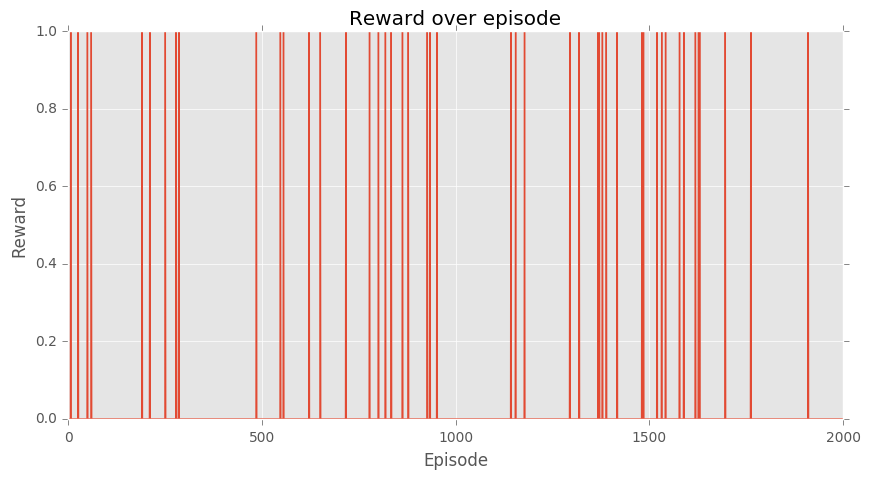

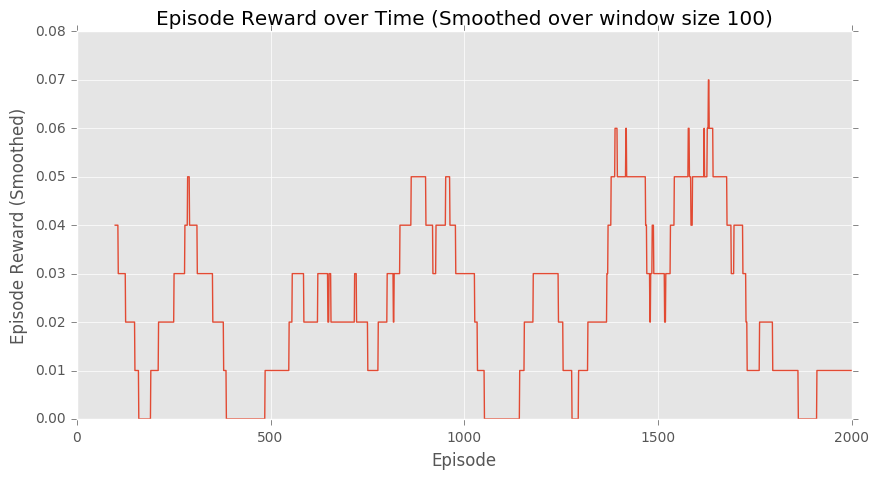

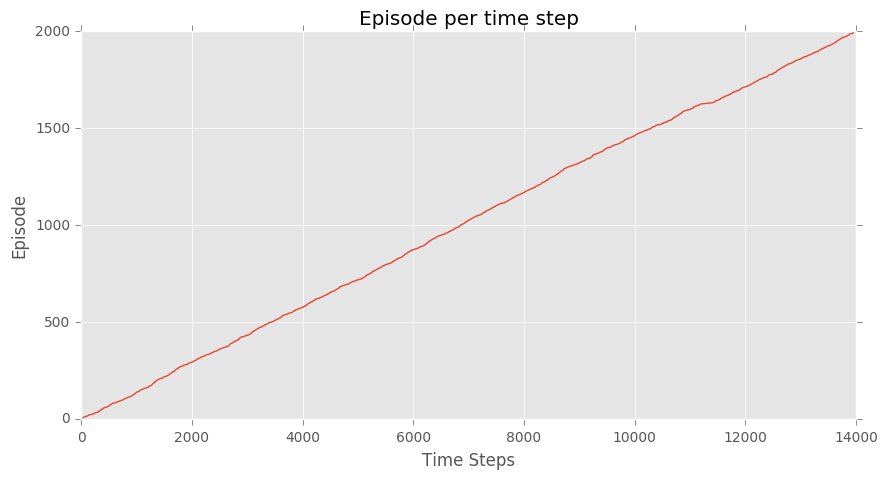

(<matplotlib.figure.Figure at 0x10bfa3048>,
 <matplotlib.figure.Figure at 0x10eee7a90>)

In [4]:
Q, stats = qlearning_noise(env)
plotting.plot_episode_stats(stats)

Q space initialized: 16 x 4
Episode 2000/2000.

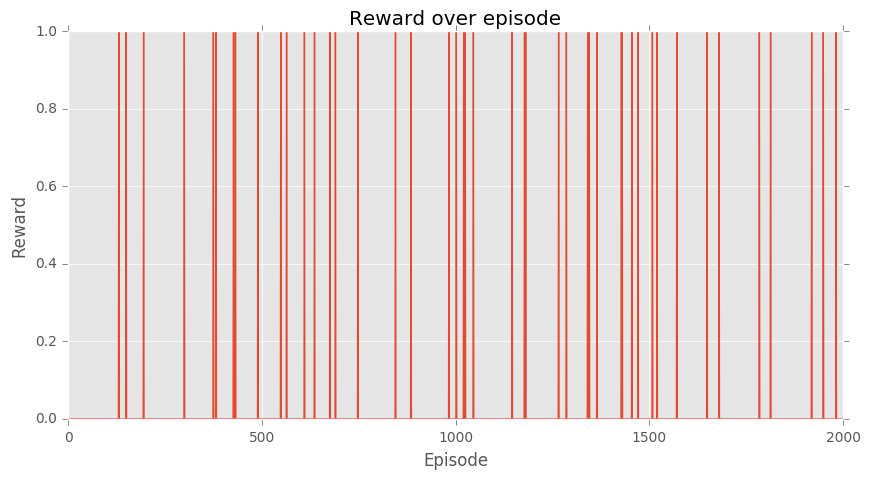

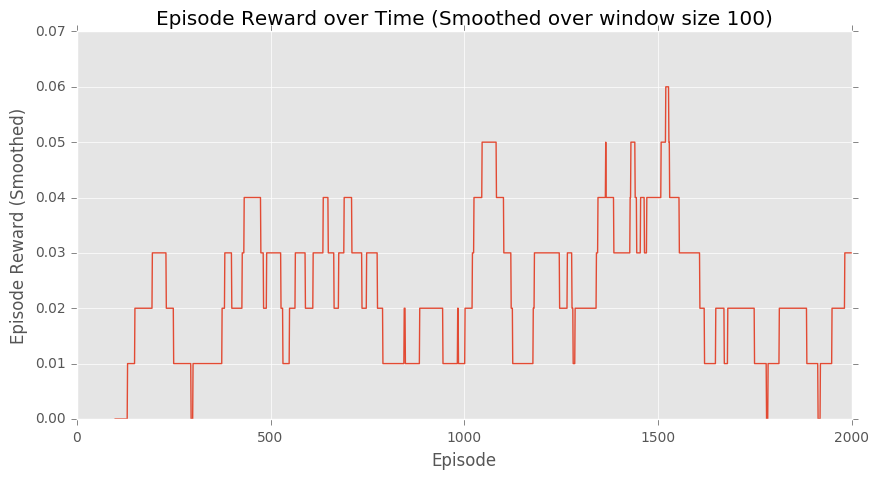

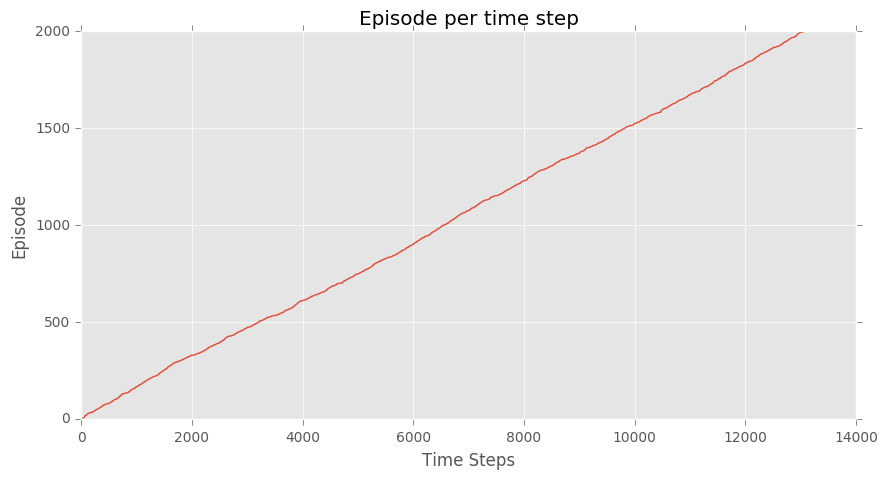

(<matplotlib.figure.Figure at 0x10ea27b00>,
 <matplotlib.figure.Figure at 0x10f35a710>)

In [5]:
Q, stats = qlearning_e_greedy(env)
plotting.plot_episode_stats(stats)

## Q-learning with alpha and decaying epsilon greedy policy

In [10]:
def qlearning_alpha_e_greedy(env, n_episodes=2000, gamma=0.99, alpha=0.85, best_enabled=False):
    nS = env.observation_space.n
    nA = env.action_space.n
    
    if best_enabled:
        # record your best-tuned hyperparams here
        env.seed(0)
        np.random.seed(0)
        alpha = 0.05
        gamma = 0.99
        epsilon_decay = 0.95
        e = 1.0

    Q = np.zeros([nS, nA])
    policy = make_decay_e_greedy_policy(Q, nA)

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(n_episodes),
        episode_rewards=np.zeros(n_episodes))

    for i in range(n_episodes):
        # useful for debuggin
        log_episode(i, n_episodes)

        s = env.reset()
        done = False
        total_reward = 0

        if best_enabled:
            e *= epsilon_decay
        else:
            e = 1.0 /((i/10) + 1.0)

        for t in itertools.count():
            # Choose action by decaying e-greedy
            probs = policy(s, e)
            a = np.random.choice(np.arange(nA), p=probs)
            # take a step
            next_s, r, done, _ = env.step(a)

            if best_enabled:
                mod_r = modify_reward(r, done)
                td_target = mod_r + gamma * np.max(Q[next_s, :])
            else:
                td_target = r + gamma * np.max(Q[next_s, :])

            td_delta = td_target - Q[s, a]
            Q[s, a] += alpha * td_delta

            s = next_s
            total_reward += r

            if done:
                break

        # Update statistics
        stats.episode_rewards[i] += total_reward
        stats.episode_lengths[i] = t

    return Q, stats


def make_decay_e_greedy_policy(Q, nA):
    def policy_fn(state, epsilon):
        # give every action an equal prob of e / n(A)
        A = np.ones(nA, dtype=float) * epsilon / nA
        # random argmax
        m = np.max(Q[state, :])
        max_indices = np.where(Q[state, :]==m)[0]
        best_action = np.random.choice(max_indices)
        # give the best action a bump prob of 1 - e
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn


def modify_reward(reward, done):
    # 100.0 being arbitrary scaling factors
    if done and reward == 0:
        return -100.0
    elif done:
        return 100.0
    else:
        return -1.0

## Q-learning with alpha and noise

In [14]:
def qlearning_alpha_noise(env, n_episodes=2000, gamma=0.99, alpha=0.85, best_enabled=False):
    if best_enabled:
        # record your best-tuned hyperparams here
        env.seed(0)
        np.random.seed(0)
        alpha = 0.05
        gamma = 0.99

    nS = env.observation_space.n
    nA = env.action_space.n
    Q = np.zeros([nS, nA])
    policy = make_decay_noisy_policy(Q, nA)

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(n_episodes),
        episode_rewards=np.zeros(n_episodes))

    for i in range(n_episodes):
        # useful for debugging
        log_episode(i, n_episodes)

        s = env.reset()
        done = False
        total_reward = 0

        for t in itertools.count():
            if best_enabled:
                probs = policy(s, (i/10 + 1.0))
            else:
                probs = policy(s, i + 1.0)
            a = np.random.choice(np.arange(nA), p=probs)

            next_s, r, done, _ = env.step(a)

            if best_enabled:
                mod_r = modify_reward(r, done)
                td_target = mod_r + gamma * np.max(Q[next_s, :])
            else:
                td_target = r + gamma * np.max(Q[next_s, :])

            td_delta = td_target - Q[s, a]
            Q[s, a] += alpha * td_delta


            s = next_s
            total_reward += r

            if done:
                break

        # Update statistics
        stats.episode_rewards[i] += total_reward
        stats.episode_lengths[i] = t

    return Q, stats

def make_decay_noisy_policy(Q, nA):
    def policy_fn(state, decaying_factor):
        noise = np.random.randn(1, nA) / decaying_factor
        # don't manually break ties as being of equal values is unlikely
        dist = Q[state, :]
        best_action = np.argmax(dist + noise)
        # make the policy deterministic as per argmax
        return np.eye(nA, dtype=float)[best_action]
    return policy_fn

def modify_reward(reward, done):
    # 100.0 being arbitrary scaling factors
    if done and reward == 0:
        return -100.0
    elif done:
        return 100.0
    else:
        return -1.0

Exception ignored in: <bound method Env.__del__ of <_Monitor<TimeLimit<FrozenLakeEnv instance>>>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/site-packages/gym/core.py", line 252, in __del__
    self.close()
  File "/usr/local/lib/python3.5/site-packages/gym/core.py", line 190, in close
    self._close()
  File "/usr/local/lib/python3.5/site-packages/gym/wrappers/monitoring.py", line 38, in _close
    self._monitor.close()
  File "/usr/local/lib/python3.5/site-packages/gym/monitoring/monitor_manager.py", line 193, in close
    self._flush(force=True)
  File "/usr/local/lib/python3.5/site-packages/gym/monitoring/monitor_manager.py", line 183, in _flush
    'env_info': self._env_info(),
  File "/usr/local/lib/python3.5/site-packages/gym/monitoring/monitor_manager.py", line 300, in _env_info
    if self.env.spec:
  File "/usr/local/lib/python3.5/site-packages/gym/monitoring/monitor_manager.py", line 98, in env
    raise error.Error("env has been garbage collected. 

[2017-03-16 15:28:56,083] Making new env: FrozenLake-v0
[2017-03-16 15:28:56,094] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0


Episode 2000/2000.pisode 200/2000.did not pass the openai criteria


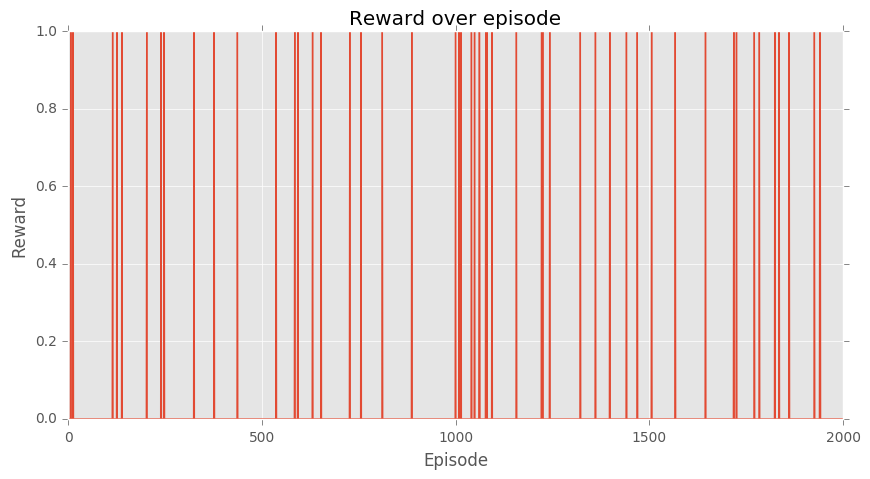

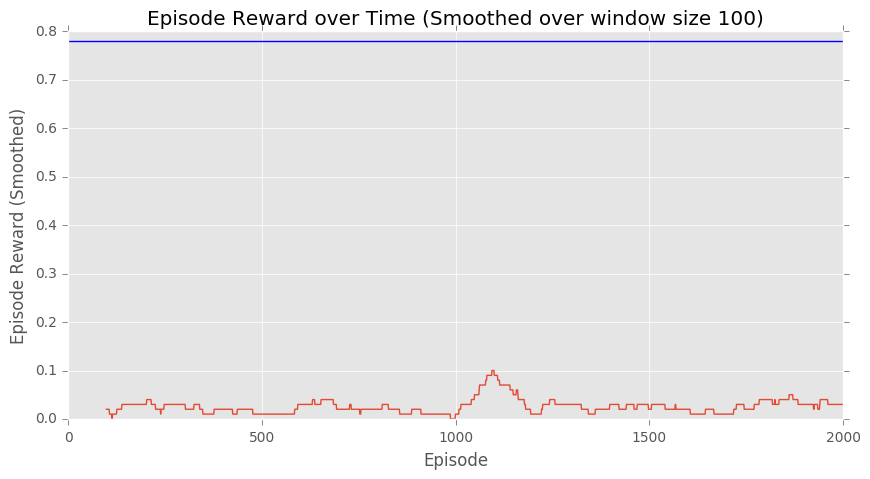

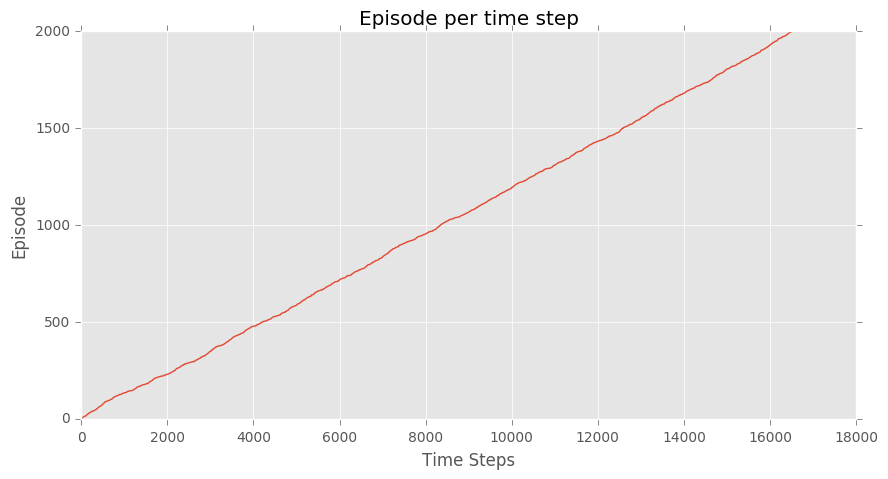

(<matplotlib.figure.Figure at 0x1139cba90>,
 <matplotlib.figure.Figure at 0x113fc5400>)

In [17]:
env = gym.make('FrozenLake-v0')
env = wrappers.Monitor(env, '/tmp/frozenlake-alpha-e', force=True, video_callable=False)
Q, stats = qlearning_alpha_e_greedy(env, best_enabled=True)

# check if we passed
if is_solved(stats, TARGET_AVG_REWARD, TARGET_EPISODE_INTERVAL):
    env.close()
    gym.upload('/tmp/frozenlake-alpha-e', api_key=OPENAI_API_KEY)

plotting.plot_episode_stats(stats, goal=TARGET_AVG_REWARD)

[2017-03-16 15:28:11,547] Making new env: FrozenLake-v0
[2017-03-16 15:28:11,562] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0


Episode 2000/2000.pisode 200/2000.did not pass the openai criteria


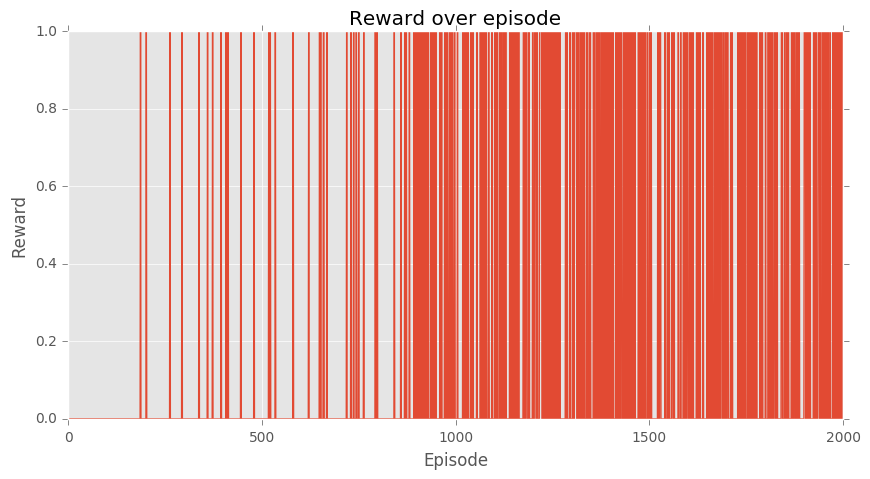

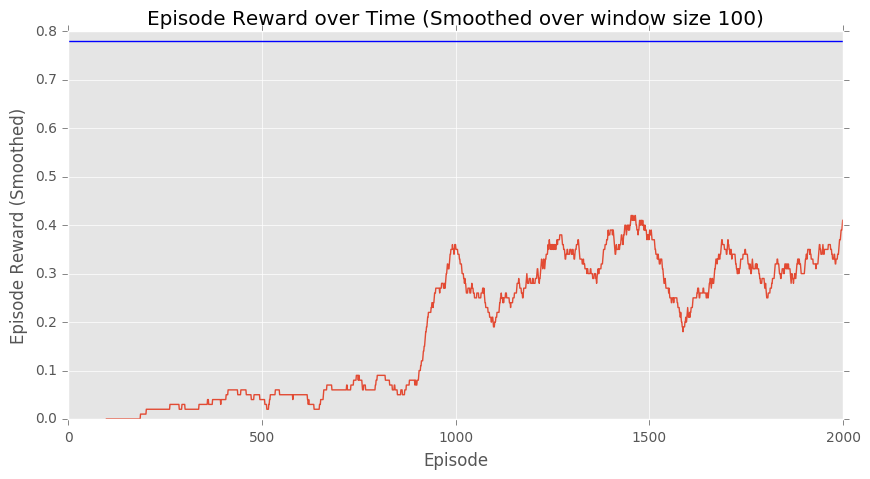

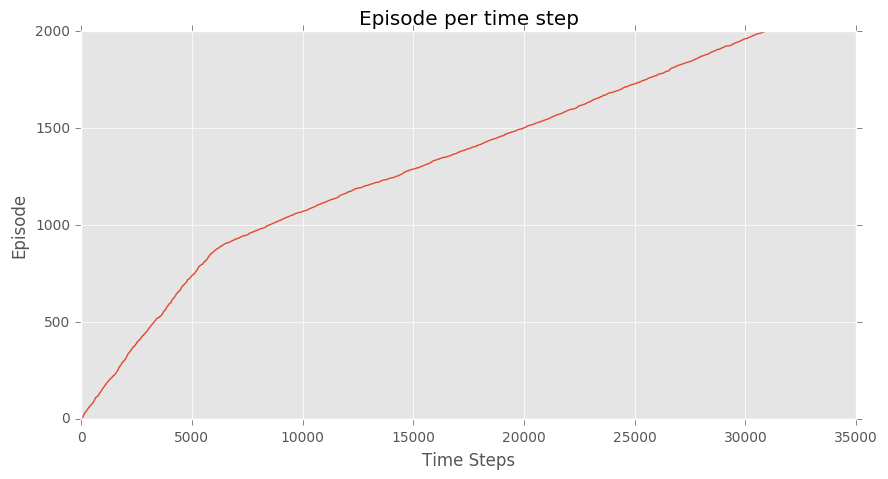

(<matplotlib.figure.Figure at 0x1127c9940>,
 <matplotlib.figure.Figure at 0x1134e0eb8>)

In [16]:
env = gym.make('FrozenLake-v0')
env = wrappers.Monitor(env, '/tmp/frozenlake-alpha-noise', force=True, video_callable=False)
Q, stats = qlearning_alpha_noise(env, best_enabled=True)

# check if we passed
if is_solved(stats, TARGET_AVG_REWARD, TARGET_EPISODE_INTERVAL):
    env.close()
    gym.upload('/tmp/frozenlake-alpha-noise', api_key=OPENAI_API_KEY)

plotting.plot_episode_stats(stats, goal=TARGET_AVG_REWARD)

## SARSA (no decaying epsilon)

In [25]:
def sarsa(env, n_episodes=2000, gamma=0.99, alpha=0.5, e=0.1, best_enabled=False):
    nS = env.observation_space.n
    nA = env.action_space.n

    if best_enabled:
        # record your best-tuned hyperparams here
        env.seed(0)
        np.random.seed(0)
        alpha = 0.05
        gamma = 0.99
        e = 1.0

    Q = np.zeros([nS, nA])
    policy = make_epsilon_greedy_policy(Q, nA)

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(n_episodes),
        episode_rewards=np.zeros(n_episodes))

    for i in range(n_episodes):
        # useful for debuggin
        log_episode(i, n_episodes)

        s = env.reset()
        done = False
        total_reward = 0

        probs = policy(s, e)
        a = np.random.choice(np.arange(nA), p=probs)

        for t in itertools.count():
            # Choose action by decaying e-greedy
            # take a step
            next_s, r, done, _ = env.step(a)

            next_probs = policy(next_s, e)
            next_a = np.random.choice(np.arange(nA), p=next_probs)

            if best_enabled:
                mod_r = modify_reward(r, done)
                td_target = mod_r + gamma * Q[next_s, next_a]
            else:
                td_target = r + gamma * Q[next_s, next_a]

            td_delta = td_target - Q[s, a]
            Q[s, a] += alpha * td_delta

            s = next_s
            a = next_a
            total_reward += r

            if done:
                break

        # Update statistics
        stats.episode_rewards[i] += total_reward
        stats.episode_lengths[i] = t

    return Q, stats


def make_epsilon_greedy_policy(Q, nA):
    def policy_fn(state, epsilon):
        # give every action an equal prob of e / n(A)
        A = np.ones(nA, dtype=float) * epsilon / nA
        # random argmax
        m = np.max(Q[state, :])
        max_indices = np.where(Q[state, :]==m)[0]
        best_action = np.random.choice(max_indices)
        # give the best action a bump prob of 1 - e
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn


def modify_reward(reward, done):
    # 100.0 being arbitrary scaling factors
    if done and reward == 0:
        return -100.0
    elif done:
        return 100.0
    else:
        return -1.0

[2017-03-16 15:49:57,640] Making new env: FrozenLake-v0
[2017-03-16 15:49:57,652] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0


Episode 2000/2000.pisode 200/2000.

[2017-03-16 15:50:03,506] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/frozenlake-experiment-1')


did not pass the openai criteria


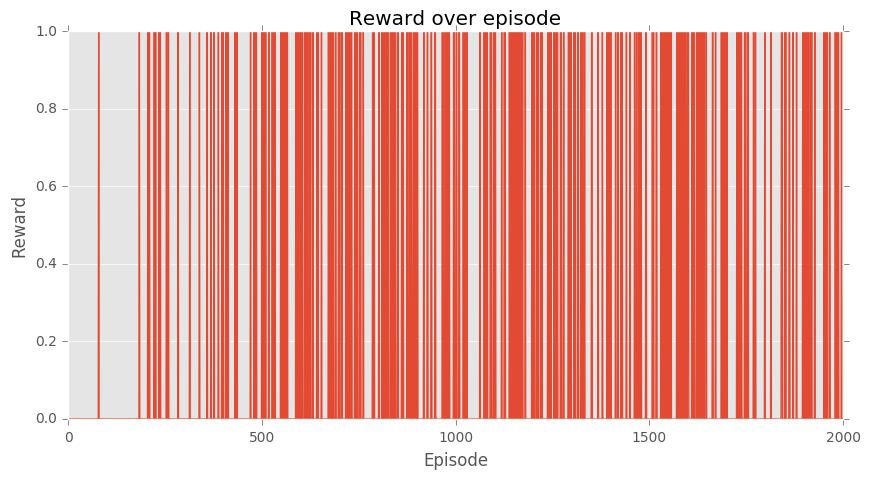

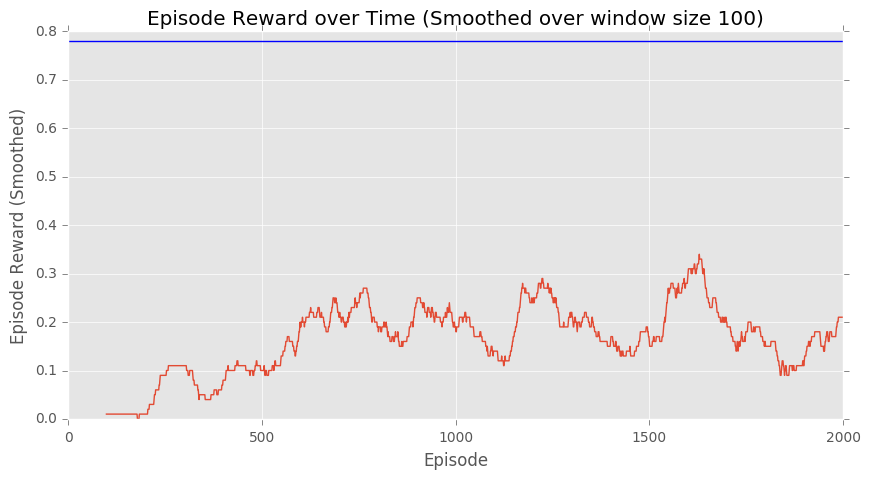

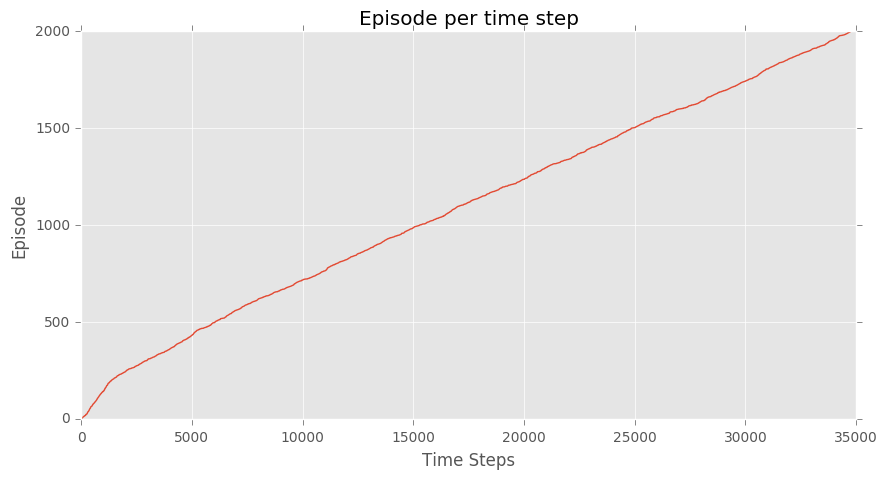

(<matplotlib.figure.Figure at 0x115632b00>,
 <matplotlib.figure.Figure at 0x11619f400>)

In [26]:
env = gym.make('FrozenLake-v0')
env = wrappers.Monitor(env, '/tmp/frozenlake-experiment-1', force=True, video_callable=False)
Q, stats = sarsa(env)
env.close()

if is_solved(stats, TARGET_AVG_REWARD, TARGET_EPISODE_INTERVAL):
    OPENAI_API_KEY = os.environ['OPENAI_API_KEY']
    gym.upload('/tmp/frozenlake-experiment-1', api_key=OPENAI_API_KEY)
plotting.plot_episode_stats(stats, goal=TARGET_AVG_REWARD)